<a href="https://www.kaggle.com/code/hamzaghanmi/tps-april-tensorflow-bi-lstm?scriptVersionId=92360737" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import tensorflow as tf
import time, logging, gc
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import roc_auc_score

from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.callbacks import *
from sklearn.model_selection import KFold, GroupKFold
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt   

In [25]:
train = pd.read_csv('../input/tabular-playground-series-apr-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-apr-2022/test.csv')
submission = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")
labels = pd.read_csv("../input/tabular-playground-series-apr-2022/train_labels.csv")
groups = train["sequence"]

# EDA

In [26]:
train.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


In [27]:
test.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,684,0,2.427357,19.639706,1.0,-1.466372,-1.289973,-4.207928,2.486339,-2.493893,8.0,-1.123555,-1.673048,10.980453,0.419011
1,25968,684,1,-4.950541,-21.747899,1.0,0.983186,-0.569053,1.845924,-3.887978,1.727481,-2.9,0.395231,-0.882233,-1.871399,-0.008525
2,25968,684,2,1.136012,-10.756303,1.0,1.016814,0.964157,2.454749,0.312386,1.154198,-5.6,1.114162,1.525273,-11.584362,0.139812
3,25968,684,3,0.806028,6.504202,1.0,-0.179646,0.969221,-1.035153,-0.457195,0.254962,-2.7,-0.588873,0.608761,-4.241770,-0.462916
4,25968,684,4,1.288253,5.552521,1.0,-0.493805,-1.036124,-1.126402,2.008197,-0.730534,0.0,0.899566,-1.259615,-0.472222,-0.121483


In [28]:
labels.head()

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


## <h4> Data Description </h4>
* <b>sequence</b> - a unique id for each sequence 
* <b>subject</b> - a unique id for the subject in the experiment
* <b>step</b> - time step of the recording, in one second intervals
* <b>sensor_00 - sensor_12</b> - the value for each of the thirteen sensors at that time step 
* <b>state</b> - the value for each of the thirteen sensors at that time step
## <h4> Objective 🤾🏻‍♂️ </h4>
* For each sequence in the test set, we will predict a probability for the state variable

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558080 entries, 0 to 1558079
Data columns (total 16 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   sequence   1558080 non-null  int64  
 1   subject    1558080 non-null  int64  
 2   step       1558080 non-null  int64  
 3   sensor_00  1558080 non-null  float64
 4   sensor_01  1558080 non-null  float64
 5   sensor_02  1558080 non-null  float64
 6   sensor_03  1558080 non-null  float64
 7   sensor_04  1558080 non-null  float64
 8   sensor_05  1558080 non-null  float64
 9   sensor_06  1558080 non-null  float64
 10  sensor_07  1558080 non-null  float64
 11  sensor_08  1558080 non-null  float64
 12  sensor_09  1558080 non-null  float64
 13  sensor_10  1558080 non-null  float64
 14  sensor_11  1558080 non-null  float64
 15  sensor_12  1558080 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 190.2 MB


In [30]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733080 entries, 0 to 733079
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sequence   733080 non-null  int64  
 1   subject    733080 non-null  int64  
 2   step       733080 non-null  int64  
 3   sensor_00  733080 non-null  float64
 4   sensor_01  733080 non-null  float64
 5   sensor_02  733080 non-null  float64
 6   sensor_03  733080 non-null  float64
 7   sensor_04  733080 non-null  float64
 8   sensor_05  733080 non-null  float64
 9   sensor_06  733080 non-null  float64
 10  sensor_07  733080 non-null  float64
 11  sensor_08  733080 non-null  float64
 12  sensor_09  733080 non-null  float64
 13  sensor_10  733080 non-null  float64
 14  sensor_11  733080 non-null  float64
 15  sensor_12  733080 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 89.5 MB


In [31]:
features  = [col for col in test.columns if col not in ("sequence","step","subject")]

In [32]:
train[features].describe() 

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
count,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06
mean,4.365526e-04,-1.034982e-03,-2.178045e-01,-2.156555e-03,-1.828903e-03,-1.651785e-03,-4.122917e-04,-2.620665e-05,-1.298393e-04,1.365584e-03,3.315801e-04,-3.733291e-03,-1.172605e-02
std,2.658684e+00,4.404200e+00,2.298002e+00,3.934184e+00,1.683685e+00,1.590818e+00,3.345143e+00,3.243428e+00,4.501534e+00,2.592913e+00,1.917333e+00,4.532568e+00,3.911767e+01
min,-3.750634e+02,-4.345977e+02,-3.165948e+01,-4.083761e+02,-2.362601e+01,-7.498280e+01,-4.705046e+02,-4.070115e+02,-5.361000e+02,-2.703468e+02,-4.341271e+01,-4.270586e+02,-6.125494e+02
25%,-5.000000e-01,-4.831933e-01,-6.461531e-01,-4.929204e-01,-4.729928e-01,-4.786836e-01,-4.927140e-01,-5.022901e-01,-5.000000e-01,-5.151734e-01,-4.787939e-01,-4.835391e-01,-5.805627e-01
50%,-3.091190e-03,3.151261e-03,0.000000e+00,0.000000e+00,-1.589577e-03,2.991773e-03,9.107468e-04,-2.290076e-03,0.000000e+00,-1.445087e-03,-1.655822e-03,3.086420e-03,0.000000e+00
75%,4.845440e-01,4.926471e-01,3.338469e-01,4.893805e-01,4.701565e-01,5.056096e-01,4.927140e-01,4.847328e-01,5.000000e-01,5.086705e-01,4.780386e-01,4.938272e-01,5.703325e-01
max,3.358246e+02,4.495914e+02,1.666667e+00,4.366504e+02,2.487286e+01,7.791548e+01,4.425009e+02,3.312542e+02,6.301000e+02,3.679812e+02,4.186559e+01,4.480206e+02,6.305111e+02


In [33]:
# adding labels to train data
train = pd.merge(train, labels,how='left', on="sequence")

In [34]:
# data for the first 60 seconds
train[train['sequence']==0]

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,state
0,0,47,0,-0.196291,0.112395,1.000000,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492,0
1,0,47,1,-0.447450,0.134454,1.000000,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390,0
2,0,47,2,0.326893,-0.694328,1.000000,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147,0
3,0,47,3,0.523184,0.751050,1.000000,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241,0
4,0,47,4,0.272025,1.074580,1.000000,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359,0
5,0,47,5,-1.073416,-1.714286,1.000000,-1.492920,0.469736,0.713538,-1.792350,-1.082443,-0.5,0.314306,0.664594,-1.682099,-2.838448,0
6,0,47,6,0.350850,0.439076,1.000000,0.870796,-0.596964,0.923710,0.769581,0.666412,0.2,-0.723266,-1.691552,0.842593,1.849531,0
7,0,47,7,-0.304482,-0.379202,1.000000,-0.218584,-0.059983,-1.389678,-0.182149,-0.029771,0.1,-0.070809,-0.774024,-0.612140,3.300938,0
8,0,47,8,-0.216383,1.106092,1.000000,0.677876,-0.071718,-0.456993,0.296903,0.111450,0.6,-0.525289,-0.334069,1.751029,0.515772,0
9,0,47,9,0.303709,-1.744748,1.000000,-0.896460,-0.755221,-0.254301,-0.354281,-0.591603,0.0,0.151012,-0.268359,-2.033951,4.509378,0


# Feature Engineering

In [35]:
def addFeatures(df):  
    for feature in features:
        df[feature + '_lag1'] = df.groupby('sequence')[feature].shift(1)
        df.fillna(0, inplace=True)
        df[feature + '_diff1'] = df[feature] - df[feature + '_lag1']    
    return df

train = addFeatures(train)
test = addFeatures(test)

In [36]:
Window = 60

In [37]:
y = train['state'].to_numpy().reshape(-1, Window)
train.drop(["sequence","step","subject","state"], axis=1, inplace=True)
test.drop(["sequence","step","subject"], axis=1, inplace=True)

In [38]:
sc = StandardScaler()

sc.fit(train)
train = sc.transform(train)
test = sc.transform(test)

In [39]:
train = train.reshape(-1, Window, train.shape[-1])
test = test.reshape(-1, Window, train.shape[-1])

In [40]:
train.shape

(25968, 60, 39)

In [41]:
# Detect hardware, return appropriate distribution strategy
print(tf.version.VERSION)
tf.get_logger().setLevel(logging.ERROR)
try: # detect TPU
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPU(s) and enable mixed precision
    strategy = tf.distribute.MirroredStrategy() # works on GPU and multi-GPU
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.config.optimizer.set_jit(True) # XLA compilation
    tf.keras.mixed_precision.experimental.set_policy(policy)
    print('Mixed precision enabled')
print("REPLICAS: ", strategy.num_replicas_in_sync)

2.4.1


2022-04-07 10:40:28.571456: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-04-07 10:40:28.571776: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30063}
2022-04-07 10:40:28.583703: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-04-07 10:40:28.583773: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30063}


REPLICAS:  8


# Modeling

In [42]:
def plotHist(hist):
    plt.plot(hist.history["auc"])
    plt.plot(hist.history["val_auc"])
    plt.title("model performance")
    plt.ylabel("area_under_curve")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    return

In [43]:
def createModel():   
    with strategy.scope():
    
        input_layer = Input(shape=(train.shape[-2:]))
        x1 = Bidirectional(LSTM(768, return_sequences=True))(input_layer)
        
        x21 = Bidirectional(LSTM(512, return_sequences=True))(x1)
        x22 = Bidirectional(LSTM(512, return_sequences=True))(input_layer)
        l2 = Concatenate(axis=2)([x21, x22])
        
        x31 = Bidirectional(LSTM(384, return_sequences=True))(l2)
        x32 = Bidirectional(LSTM(384, return_sequences=True))(x21)
        l3 = Concatenate(axis=2)([x31, x32])
        
        x41 = Bidirectional(LSTM(256, return_sequences=True))(l3)
        x42 = Bidirectional(LSTM(128, return_sequences=True))(x32)
        l4 = Concatenate(axis=2)([x41, x42])
        
        l5 = Concatenate(axis=2)([x1, l2, l3, l4])
        x7 = Dense(128, activation='selu')(l5)
        x8 = Dropout(0.3)(x7)
        output_layer = Dense(units=1, activation="sigmoid")(x8)
        model = Model(inputs=input_layer, outputs=output_layer, name='DNN_Model')
        
        model.compile(optimizer="adam",loss="binary_crossentropy", metrics=[AUC(name = 'auc')])
    return(model)

In [44]:
model = createModel()
model.summary()

Model: "DNN_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 60, 39)]     0                                            
__________________________________________________________________________________________________
bidirectional_35 (Bidirectional (None, 60, 1536)     4964352     input_6[0][0]                    
__________________________________________________________________________________________________
bidirectional_36 (Bidirectional (None, 60, 1024)     8392704     bidirectional_35[0][0]           
__________________________________________________________________________________________________
bidirectional_37 (Bidirectional (None, 60, 1024)     2260992     input_6[0][0]                    
__________________________________________________________________________________________

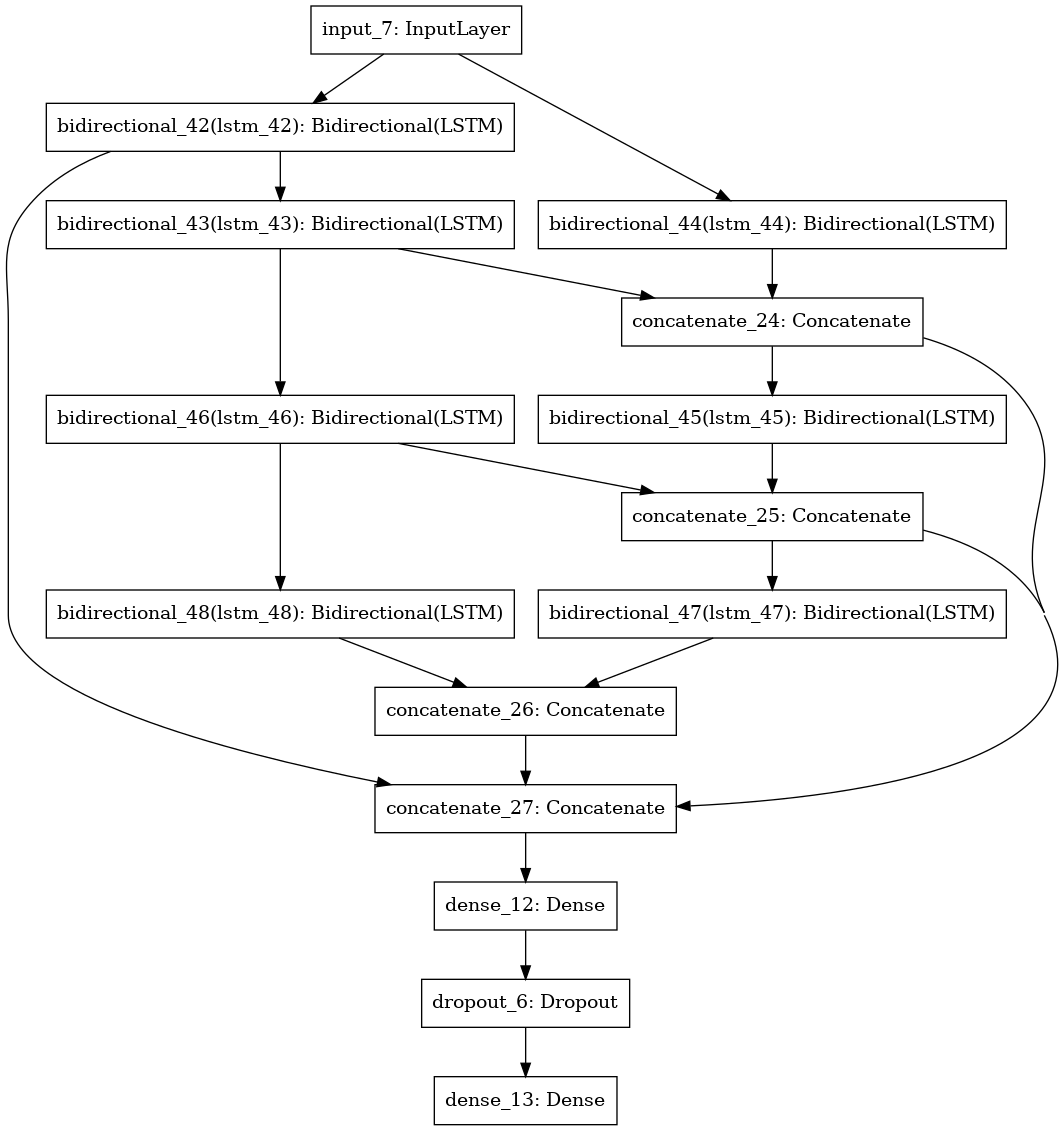

In [45]:
utils.plot_model(createModel())

** fold: 1 ** ........training ...... 

auc: 0.9654020506708956 



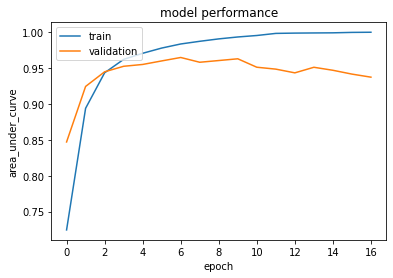

** fold: 2 ** ........training ...... 

auc: 0.9659904381228538 



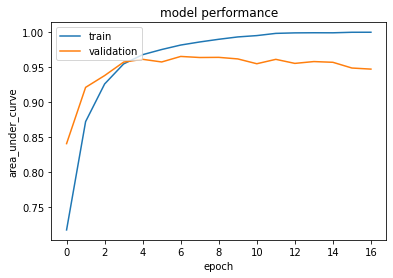

** fold: 3 ** ........training ...... 

auc: 0.9694816293048533 



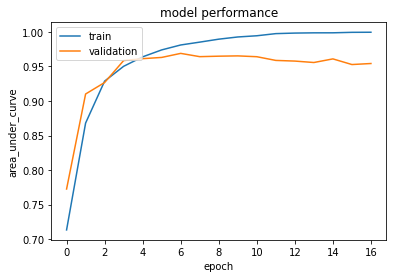

** fold: 4 ** ........training ...... 

auc: 0.9654106123864631 



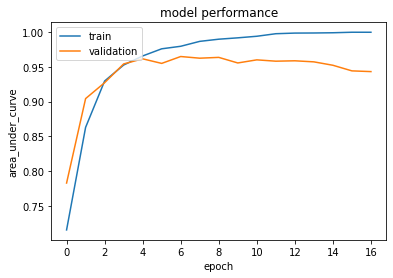

** fold: 5 ** ........training ...... 

auc: 0.9694155855456074 



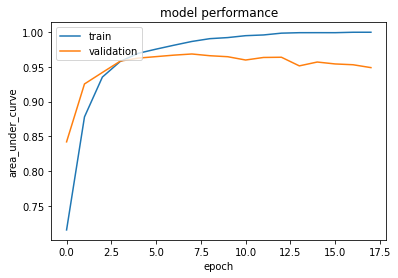

** fold: 6 ** ........training ...... 

auc: 0.9728000438929486 



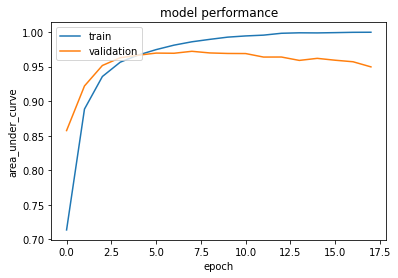

** fold: 7 ** ........training ...... 

auc: 0.9679799142004232 



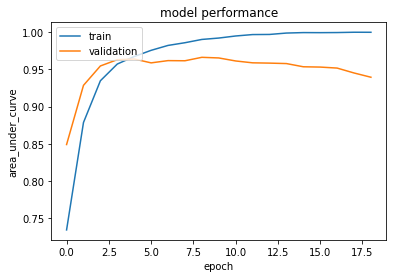

** fold: 8 ** ........training ...... 

auc: 0.9730275144007143 



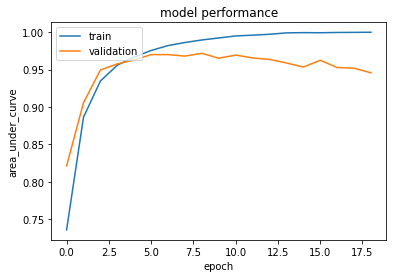

** fold: 9 ** ........training ...... 

auc: 0.9644993192807848 



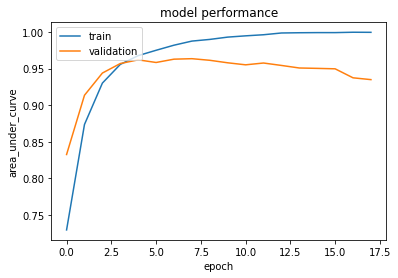

** fold: 10 ** ........training ...... 

auc: 0.9653197942971896 



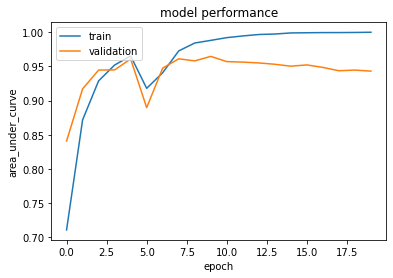

In [46]:
kf = GroupKFold(n_splits=10)
auc = []
test_preds = []
for fold, (train_idx, test_idx) in enumerate(kf.split(train, y, groups.unique())):
    print(f"** fold: {fold+1} ** ........training ...... \n")
    X_train, X_valid = train[train_idx], train[test_idx]
    y_train, y_valid = y[train_idx], y[test_idx]
    lr = ReduceLROnPlateau(monitor="val_auc", mode='max', factor=0.7, patience=4, verbose=False)
    es = EarlyStopping(monitor='val_auc',mode='max', patience=10, verbose=False,restore_best_weights=True)
    
    model = createModel()
        
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=30, batch_size = 64, callbacks = [es,lr],verbose = False)
    
    y_pred = model.predict(X_valid).squeeze()
    auc.append(roc_auc_score(y_valid, y_pred))
    print(f"auc: {auc[fold]} \n")
    test_preds.append(model.predict(test).squeeze())
    plotHist(history)
    del X_train, X_valid, y_train, y_valid, model, history
    gc.collect()  

In [47]:
print(f"the mean AUC for the {kf.n_splits} folds is : {round(np.mean(auc)*100,3)}")

the mean AUC for the 10 folds is : 96.793


# Submission

In [48]:
submission["state"] = sum(test_preds)/kf.n_splits 
submission.to_csv('submission.csv', index=False)
submission   

,sequence,state
0,25968,0.973902
1,25969,0.995814
2,25970,0.004464
3,25971,0.725940
4,25972,0.422336
...,...,...
12213,38181,0.260604
12214,38182,0.531253
12215,38183,0.122134
12216,38184,0.150681


# References:
* 1.[https://www.kaggle.com/code/ryanbarretto/lstm-baseline](https://www.kaggle.com/code/ryanbarretto/lstm-baseline)
* 2.[https://www.kaggle.com/code/hamzaghanmi/tensorflow-bi-lstm-with-tpu](https://www.kaggle.com/code/hamzaghanmi/tensorflow-bi-lstm-with-tpu)